<a href="https://colab.research.google.com/github/Deep1209G/Another-Folder/blob/main/MajorProject_for_closing_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is inc

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input, MultiHeadAttention, LayerNormalization, Flatten
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Set the path to your CSV file
file_path = '/content/Nifty-50 2020-25.csv'

# Read the CSV into a pandas DataFrame
df = pd.read_csv(file_path)

print(df.head(10))

       Date      Open      High       Low     Close   Shares Traded   \
0  01-Jul-20  10323.80  10447.05  10299.60  10430.05       573550127   
1  02-Jul-20  10493.05  10598.20  10485.55  10551.70       597423931   
2  03-Jul-20  10614.95  10631.30  10562.65  10607.35       525190704   
3  06-Jul-20  10723.85  10811.40  10695.10  10763.65       571212914   
4  07-Jul-20  10802.85  10813.80  10689.70  10799.65       636764929   
5  08-Jul-20  10818.65  10847.85  10676.55  10705.75       767941333   
6  09-Jul-20  10755.55  10836.85  10733.00  10813.45       618652409   
7  10-Jul-20  10764.10  10819.40  10713.00  10768.05       590705425   
8  13-Jul-20  10851.85  10894.05  10756.05  10802.70       554050579   
9  14-Jul-20  10750.85  10755.65  10562.90  10607.35       532368699   

   Turnover (? Cr)  
0         28736.28  
1         31235.17  
2         25186.39  
3         29857.54  
4         36502.37  
5         37676.34  
6         31315.87  
7         31557.58  
8         30606.30

In [ ]:
# Clean column names (remove extra spaces)
df.columns = df.columns.str.strip()
data = df[['Close']]

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

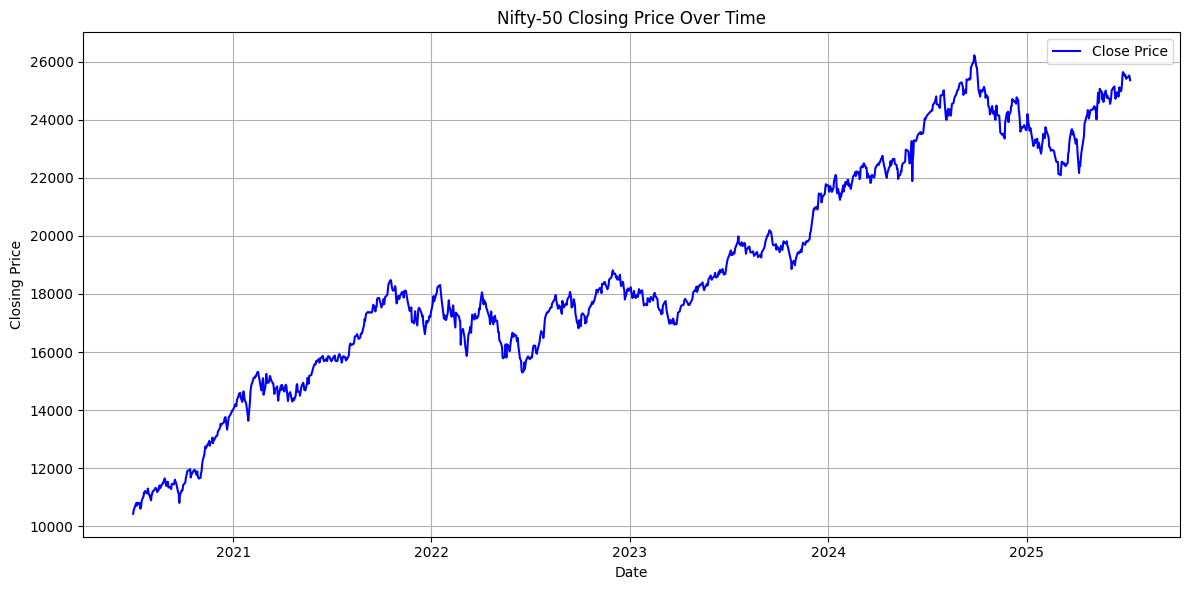

In [ ]:
# Sort by date just in case
if 'Date' in df.columns:
    df.sort_values('Date', inplace=True)
    # Reset index to align with the plot
    df.reset_index(drop=True, inplace=True)
    # Plot Closing Price over Time
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
    plt.title('Nifty-50 Closing Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Error: 'Date' column not found in the DataFrame.")
    print("Available columns:", df.columns)

In [ ]:
#shape
df.shape

(1247, 7)

In [ ]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1247 non-null   datetime64[ns]
 1   Open             1247 non-null   float64       
 2   High             1247 non-null   float64       
 3   Low              1247 non-null   float64       
 4   Close            1247 non-null   float64       
 5   Shares Traded    1247 non-null   int64         
 6   Turnover (? Cr)  1247 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.3 KB


In [ ]:
#finding missing value
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Shares Traded,0
Turnover (? Cr),0


In [ ]:
#finding duplicate
df.duplicated().sum()

np.int64(2)

In [ ]:
# it will remove duplicate value
df = df.drop_duplicates()


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# i have choose close column to normalize
data = df[['Close']]

# Normalize the 'Close' prices using MinMaxScaler (0 to 1)
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(data)

# Convert back to DataFrame (optional, to see the result nicely)
normalized_df = pd.DataFrame(normalized_data, columns=['Normalized Close'])

# Preview the result
print(normalized_df.head(10))


   Normalized Close
0          0.000000
1          0.007706
2          0.011231
3          0.021133
4          0.023413
5          0.017465
6          0.024287
7          0.021411
8          0.023606
9          0.011231


In [ ]:
# Create sequences (e.g., past 60 days → next day)
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X, y = create_dataset(normalized_data, time_step)

# Reshape input to 3D [samples, time steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Print final shapes to confirm
print(f"Shape of X (inputs): {X.shape}")
print(f"Shape of y (labels): {y.shape}")

Shape of X (inputs): (1184, 60, 1)
Shape of y (labels): (1184,)


In [ ]:
# install xgboost
!pip install xgboost

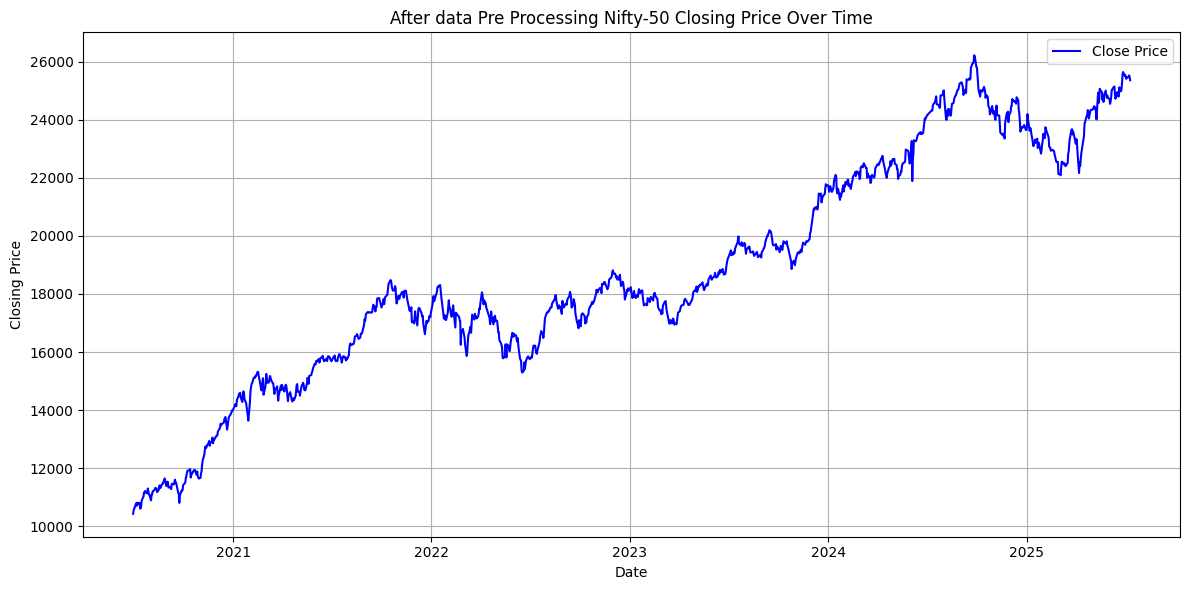

In [ ]:
# Sort by date just in case
df.sort_values('Date', inplace=True)
# Plot Closing Price over Time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('After data Pre Processing Nifty-50 Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 3. Train-Test Split (80-20, sequential)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)


Training set: (947, 60, 1) (947,)
Testing set: (237, 60, 1) (237,)



Training LSTM Model...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.2010
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0039
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 8.7131e-04
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 6.2797e-04
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 5.9679e-04
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 6.3506e-04
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 6.0665e-04
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 6.5595e-04
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 6.4394e-04
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 6.0000e-04

Training GRU Model...
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.1048
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0025
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 4.2589e-04
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 2.7157e-04
Epoch 5/10
37/37 ━━━━━

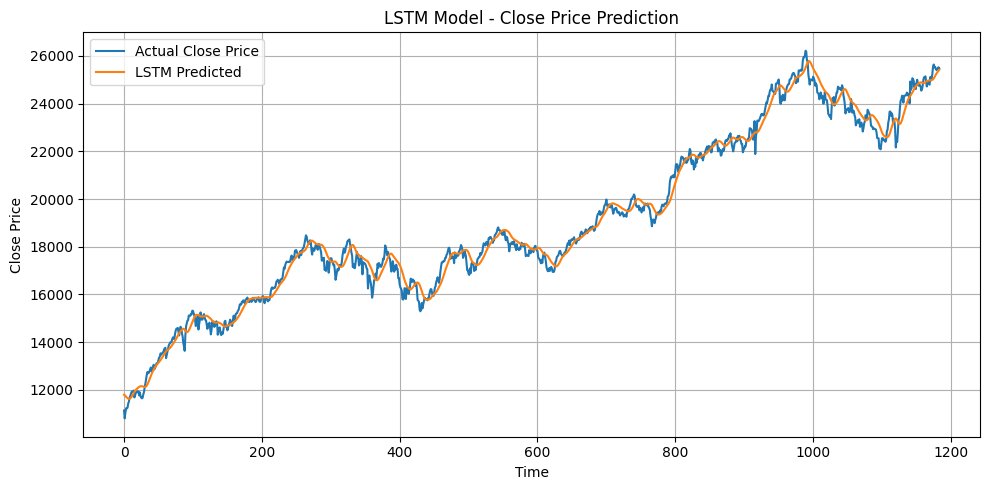

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


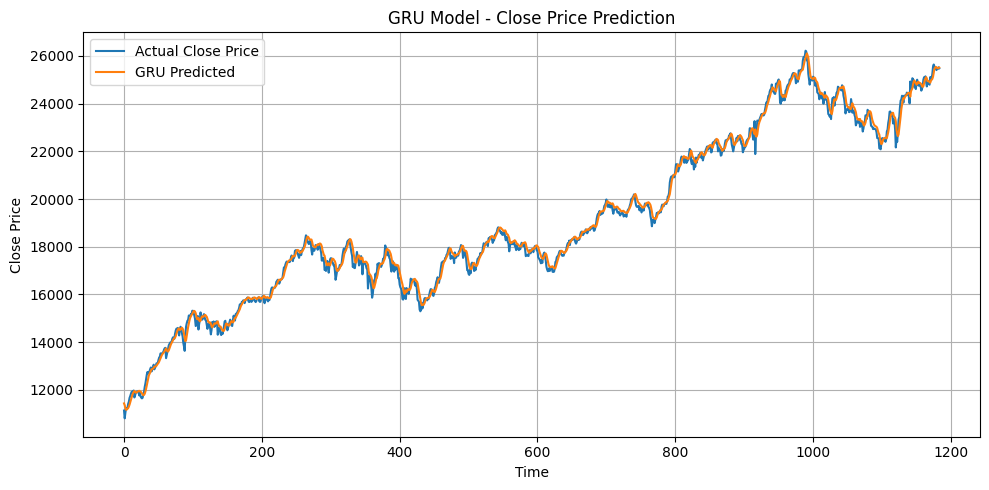

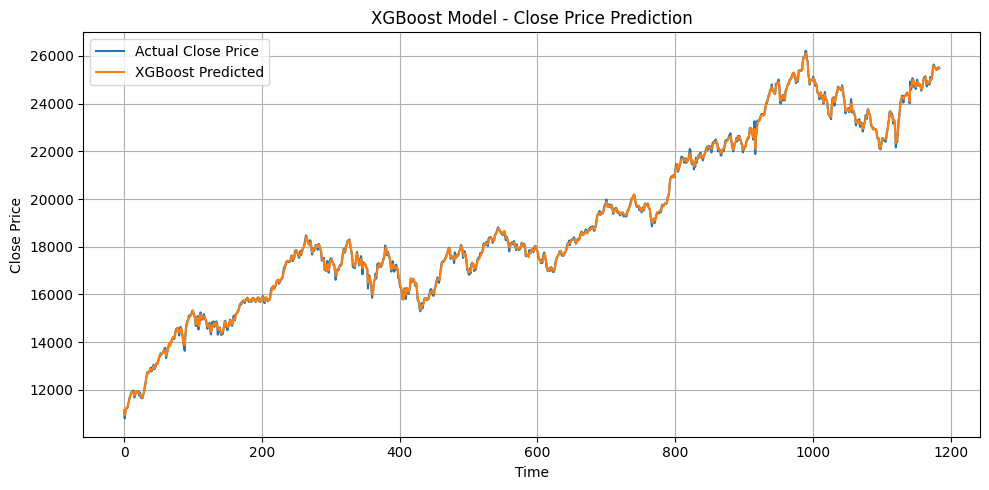

In [ ]:
# 4. LSTM Model
print("\nTraining LSTM Model...")
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X, y, epochs=10, batch_size=32)
# 5. GRU Model
print("\nTraining GRU Model...")
model_gru = Sequential([
    GRU(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    GRU(50),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.fit(X, y, epochs=10, batch_size=32)
# 6. XGBoost Model

print("\nTraining XGBoost Model...")

# Define model
model_xgb = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the XGBoost model
model_xgb.fit(X.squeeze(), y)  # XGBoost expects 2D input, so squeeze the features

# 7. Prediction Function

def plot_predictions(model, X_input, y_actual, name):
    if name == "XGBoost":
        pred = model.predict(X_input)
        pred = pred.reshape(-1, 1)
    else:  # For LSTM and GRU
        pred = model.predict(X_input)

    # Inverse transform predictions and actual values
    pred_inv = scaler.inverse_transform(pred)
    actual_inv = scaler.inverse_transform(y_actual.reshape(-1, 1))

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(actual_inv, label='Actual Close Price')
    plt.plot(pred_inv, label=f'{name} Predicted')
    plt.title(f'{name} Model - Close Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 8. Evaluation Function
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_input, y_actual, name):
    if name == "XGBoost":
        pred = model.predict(X_input)
        pred = pred.reshape(-1, 1)
    else:  # For LSTM and GRU
        pred = model.predict(X_input)

    # Inverse transform predictions and actual values
    pred_inv = scaler.inverse_transform(pred)
    actual_inv = scaler.inverse_transform(y_actual.reshape(-1, 1))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actual_inv, pred_inv))
    mae = mean_absolute_error(actual_inv, pred_inv)
    r2 = r2_score(actual_inv, pred_inv)

    # Print evaluation
    print(f"\n{name} Evaluation:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")

# 9. Run Evaluation & Plotting

# Evaluate models
evaluate_model(model_lstm, X, y, "LSTM")
evaluate_model(model_gru, X, y, "GRU")
evaluate_model(model_xgb, X.squeeze(), y, "XGBoost")  # XGBoost expects 2D input

# Plot predictions
plot_predictions(model_lstm, X, y, "LSTM")
plot_predictions(model_gru, X, y, "GRU")
plot_predictions(model_xgb, X.squeeze(), y, "XGBoost")
